## This notebook demonstrates calibrating MWR to the S-1000, 2022 landslide using the calibrator utility

### import landlab raster model grid and other python packages needed for running and visualizing the model

In [1]:
#TO DO: change so that calibrator saves model run and lines, then access after is run to create videos
#       create tool for picking profile location, additional function of calibrator  

import os

## import plotting tools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sc

## import necessary landlab components
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator
from landlab.components import(FlowDirectorD8, 
                                FlowDirectorMFD)

from landlab.components.mass_wasting_router import MassWastingRunout

## import landlab plotting functionality
from landlab import imshow_grid_at_node

## import functions
from landlab.io.esri_ascii import write_esri_ascii
from landlab.io import read_esri_ascii

from landlab.components import ChannelProfiler, FlowAccumulator, DepressionFinderAndRouter


os.chdir('C:/Users/keckje/Documents/GitHub/landlab/landlab/components/mass_wasting_router/')
#from mwru_calibrator_working_copy import (MWRu_calibrator,
from mwru_calibrator import (MWRu_calibrator,
                                profile_plot,
                                define_profile_nodes,
                                profile_distance)

os.chdir('C:/Users/keckje/Documents/GitHub/code/preevents/paper2/')
import MassWastingRunoutEvaluationFunctions as MWF

# load plotting functions
os.chdir('C:/Users/keckje/Documents/GitHub/landlab/notebooks/tutorials/landslides')
python_file = open("imshow_grid_at_node_with_alpha.txt").read()
exec(python_file)

### import other custom plotting code and functions

### DEFINE parameter range from which calibrator will search for the optimal parameter values

In [2]:
#%% input
svnm = 's1000_10m_10_ns_n'

# average thickness of landslide
mw_id = 1
UseSoilDepth = True
t_avg = 15
vary_cs = False
qsc_constraint = True
method = "both"
routing_surface = "topographic__elevation"
deposition_rule = "critical_slope"
deposit_style = 'downslope_deposit_sc10'
effective_qsi = True
qsi_max = 5
settle_deposit = False

g_erosion = True
Pd = 0.316

jump_size = 0.09
alpha_max = 0.7
alpha_min = 0.3#alpha_max-0.4
N_cycles = 100


# parameters for estimating alpha
h = 2
s = 0.25
ros = 2650
vs = 0.6
eta = 0.2


####
# calibration parameters
# min, max and best estimate of flux threshold and scour coefficient
if vary_cs:
    params = {'SD':[0.01,0.75,0.3],
              'slpc':[0.005, 0.07, 0.03],
              'cs':[0.001,0.05,0.02]}
    cs = params['cs'][2]
else:
    if g_erosion:
        cs = 0.0337443 # 0.0457309 #eta = 0.2: 0.02609*2 # doubled because a 10m grid eta = 1, 0.000287025#0.03189
    else:
        cs = 0.0226254#0.0226254 #eta = 0.2: 0.01290*2 # eta=1, 8.5084e-06#0.01578# 0.035 value used in draft 1 to authors # scour coefficient
params = {'SD':[0.01,1.75,0.3],
          'slpc':[0.005, 0.3, 0.03]} 
# low and upper extent of elevation range used to evalute profile
el_l = 230
el_h = 430

max_number_of_runs = 10
####


# GIS generated inputs
bdfdem = '2019li_5m10m_xv2.asc' # before debris flow dem
lsnodes = 'ls_poly_v5_10m.asc' # landslide poligon nodes
bdfdem_hs = '2019li_2m_xv2_hs.asc' # before debris flow dem hs
odfdem = 'dif_10m_t7.asc' # observed dem difference

# cross section xlsx file name
xlsxm = 'ProfileNodes_10m.xlsx'

# GIS input file location
dem_dir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/S1000/input/'
# cross section file location
xs_dir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/S1000/maps/S1000/'
# file location where output will be saved
mdir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/S1000/output/MCMC_v1/'


### import gis generated inputs (DEM) and set notebook controls

In [3]:
#%% load inputs
# dem
mg, z = read_esri_ascii(dem_dir+bdfdem, name='topographic__elevation')

# ls nodes
_, mw1 = read_esri_ascii(dem_dir+lsnodes, name='mass__wasting_id')
mg.add_field('node', 'mass__wasting_id',mw1.astype(int))

# observed deposition
_, mw1 = read_esri_ascii(dem_dir+odfdem, name='dem_dif_o')
mg.add_field('node', 'dem_dif_o',mw1)
mg.at_node['dem_dif_o'][mg.at_node['dem_dif_o'] == -9999] = 0 # change null values to zero

# soil depth
# here using uniform depth
depth = np.ones(mg.at_node['topographic__elevation'].shape[0])*1.2
mg.add_field('node', 'soil__thickness',depth)
# for landslide, set depth equal to field estimated average depth
if UseSoilDepth is True:
    lsdepth = 'sd_s1000_v5_10m.asc' # dem difference inferred landslide depth, may need to increase depth at lower part of landslide
    _, lsd = read_esri_ascii(dem_dir+lsdepth, name='ls_depth')
    lsd = lsd[lsd != -9999]
    mg.at_node['soil__thickness'][mg.at_node['mass__wasting_id'] == mw_id] = -1*lsd
else:
    mg.at_node['soil__thickness'][mg.at_node['mass__wasting_id'] == mw_id] = t_avg

# high res hillshade for plot background
mg_hs, hs = read_esri_ascii(dem_dir+bdfdem_hs, name='hillshade')

mg_hs.at_node['hillshade_arc'] = hs

mg.set_watershed_boundary_condition(z) # finds lowest point in dem and sets it as an open node

# add particle diameter
if g_erosion:
    mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*Pd


### view the S1000 2022 landslide body

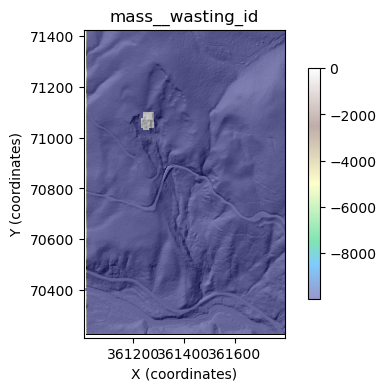

In [4]:
plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'mass__wasting_id',plot_name = 'high_res',
                                         fontsize = 10,alpha = .5,figsize = (6,4))

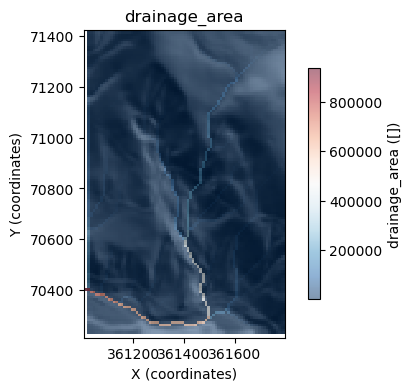

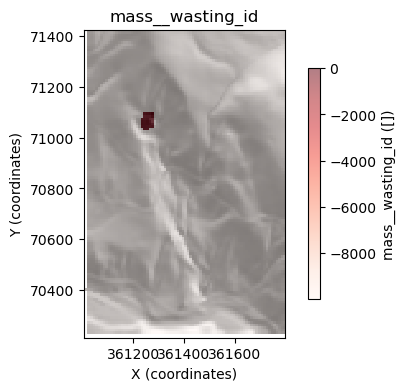

<Figure size 640x480 with 0 Axes>

In [5]:
#%% use DEM to create other needed fields
# flow accumulater to get contributing area to each grid cell
fa = FlowAccumulator(mg, 
                      'topographic__elevation',
                      flow_director='FlowDirectorD8')
fa.run_one_step()
# fill depressions to correct surface area determination
df_4 = DepressionFinderAndRouter(mg)
df_4.map_depressions()
# landlab built in hillshade
mg.at_node['hillshade'] = mg.calc_hillshade_at_node(elevs=z, alt=37., az=210.)

# vissually check inputs
plot_node_field_with_shaded_dem(mg,field = 'drainage_area', fontsize = 10,cmap = 'RdBu_r',alpha = .5,figsize = (6,4))
plot_node_field_with_shaded_dem(mg,field = 'mass__wasting_id', fontsize = 10,cmap = 'Reds',alpha = .5, figsize = (6,4))
plt.figure()
# save an copy of the initial elevation for dem differencing
_ = mg.add_field('topographic__initial_elevation',
                    mg.at_node['topographic__elevation'],
                    at='node',
                    copy = True)
# multiflow direction for MWRu
# need to delete d8 flow direction
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')
# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'slope')
fd.run_one_step()

In [6]:
qsi_max

5

### set model parameters and instantiate MWR!!!!

In [7]:

# debris flow control parameters
# how is the volume released
npu = [1] # sL = [8,10,25] # number of pulses, list for each landslide
nid = [1] #[5,5,5] # delay between pulses (iterations), list for each landslide
SD = params['SD'][2]
Sc = params['slpc'][2]
tracked_attributes = ['particle__diameter']

mw_dict = {'critical slope':[Sc], 'threshold flux':SD,
            'erosion coefficient':cs, 'erosion exponent':eta,
            'effective particle diameter':Pd, 'vol solids concentration':vs,
            'density solids':ros, 'typical flow thickness, scour':h,
            'typical slope, scour':s, 'max observed flow depth': qsi_max }

release_dict = {'number of pulses':npu, 'iteration delay':nid }

DebrisFlows = MassWastingRunout(mg, 
                                critical_slope = [Sc],
                                threshold_flux = SD,
                                erosion_coefficient = cs,
                                erosion_exponent = eta,
                                typical_slope_of_erosion_zone = s,
                                max_flow_depth_observed_in_field = qsi_max,
                                tracked_attributes = tracked_attributes,
                                save = False,
                                settle_deposit = settle_deposit,
                                effective_qsi = effective_qsi)# DebrisFlowScourAndDeposition(mg, df_para_dict)

# # add a Dp class variable
# DebrisFlows.Dp = DebrisFlows._grid.at_node['particle__diameter'].mean()

 running with spatially variable Dp 


### load channel nodes, and look at the observed topographic change caused by the landslide

In [8]:
# use predefined profile or create your own by uncommenting lower code block
# pre-defined profile
pnodes = np.array([7141, 7061, 7062, 6982, 6902, 6903, 6823, 6743, 6744, 6664, 6665, 6585, 6505, 6506, 6426, 6346, 6347, 6267, 6268, 6188, 6108, 6028, 5948, 5868, 5788, 5789, 5709, 5629, 5549, 5469, 5470, 5390, 5310, 5311, 5312, 5232, 5233, 5153, 5154, 5074, 4994, 4914, 4834, 4754,4674, 4594, 4595, 4515, 4435, 4436, 4356, 4276, 4196, 4116, 4036,3956, 3876, 3796, 3716, 3715, 3635, 3555, 3475, 3476, 3396, 3316,3317, 3237, 3238, 3158, 3078, 3079, 2999, 2919, 2839, 2759, 2760,2680, 2681, 2601, 2521, 2522, 2442, 2362, 2282, 2283, 2284, 2204,2205, 2125, 2045, 2046, 1966, 1886, 1806, 1726, 1646, 1645, 1565,1485, 1405, 1325, 1326, 1246, 1166, 1167, 1087, 1007,  927,  928,848,  768,  688,  608,  528,  527,  447,  446,  445,  444,  443,363,  362,  361,  360,  359,  439,  438,  437,  436,  435,  434,433,  353,  352,  351,  350,  349,  348,  428,  427,  426,  425,424,  504,  584,  583])
pnodedist = np.array([    0. ,     4.2,    11.2,    15.6,    27. ,    31.4,    38.6,50.1,    51.7,    61.6,    72.1,    73.1,    84.5,    92.3,96.1,   107.5,   112.6,   125.7,   130.5,   138.2,   143.9,153.9,   163.9,   173.9,   184.9,   194.9,   200.5,   213.8,223.4,   228.7,   236.3,   246.2,   252.8,   253.1,   266.6,267.7,   280. ,   282.7,   295. ,   296.8,   306.8,   316.8,326.8,   336.9,   346.9,   358.7,   365.7,   369.1,   381.8,388.3,   393.2,   403.2,   413.2,   423.2,   433.2,   443.2,453.2,   469.3,   473.2,   477.1,   483.2,   498.5,   503.7,509.3,   520.8,   526.1,   530.9,   543.2,   549.3,   549.9,563. ,   570.3,   574.7,   584.7,   599.5,   607.4,   613.3,623.1,   631. ,   636. ,   646. ,   652.9,   660.2,   671.8,679. ,   679.2,   693.1,   693.4,   706.9,   713.1,   723.5,731.3,   740. ,   744.4,   754.4,   769.1,   774.3,   779.5,784.4,   794.4,   808.7,   816.7,   824.3,   828.9,   844.4,851. ,   857.7,   869.4,   875.9,   884.5,   888.6,   898.6,908.6,   922.8,   928.6,   929.9,   938.6,   944.2,   944. ,944.2,   949.5,   957.8,   957.6,   957.1,   956.6,   968.8,964.8,   968.8,   968.8,   968.8,   968.8,   968.8,   975.4,981.1,   981.2,   981.4,   981.5,   991.5,   986. ,   992.1,992. ,   991.8,  1012.9,  1007.7,  1007.3,   997.3,   997. ])

In [9]:
# uncomment the two lines below and run this box to define your own profile

# %matplotlib qt
# pnodes, pnodedist, Lxy = define_profile_nodes(mg)

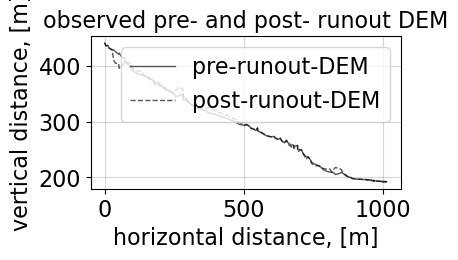

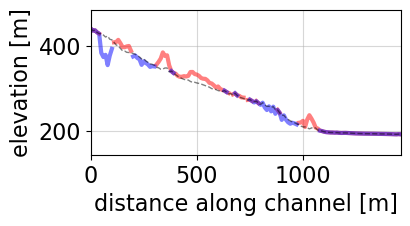

In [10]:
#%% visualize profile and plan view depositional patterns
#view_profile_nodes(mg,xsd,'hillshade',cmap = 'Greys')
%matplotlib inline
profile_plot(mg, pnodes, pnodedist, aspect = 2,figsize = (4,2), fs = 16)
MWF.profile_deposition_scour(mg, pnodes, field = 'dem_dif_o',  ef = 5, aspect = 2,figsize = (4,2), fs = 16)

In [11]:
#%% define the paramete sampling space and parameters for determing the profile metric
profile_calib_dict = {"el_l":el_l, "el_h": el_h, "runout_profile_nodes": pnodes,
                      "runout_profile_distance":pnodedist, "cL": mg.dx}


In [12]:
#%% instantiate the calibration class
# Initialize the Dream Class
calibrate = MWRu_calibrator(DebrisFlows, params, profile_calib_dict = profile_calib_dict, N_cycles = N_cycles,
                            prior_distribution = "uniform", jump_size = jump_size, alpha_max = alpha_max, alpha_min=alpha_min,
                            plot_tf = True, qsc_constraint = qsc_constraint,
                            method = method, seed = 7)

E<qsc


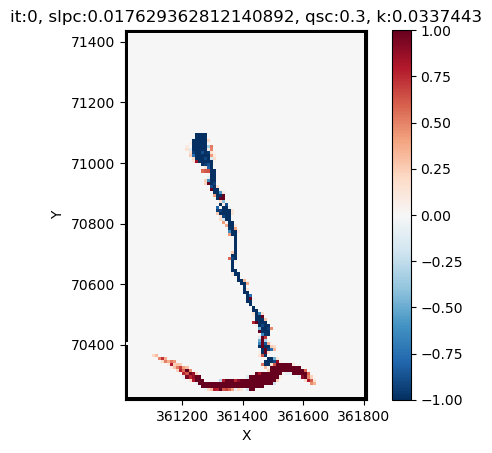

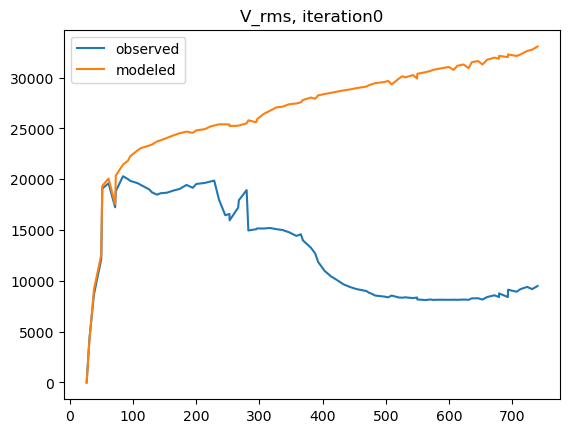

MCMC iteration: 0, likelihood:13.27474, acceptance ratio:1, random value:[ 0.978],jumped to new value
E<qsc


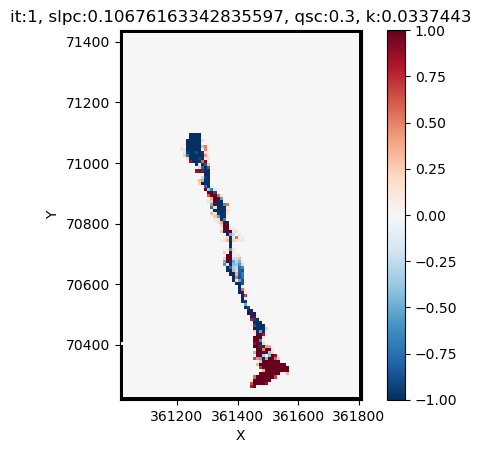

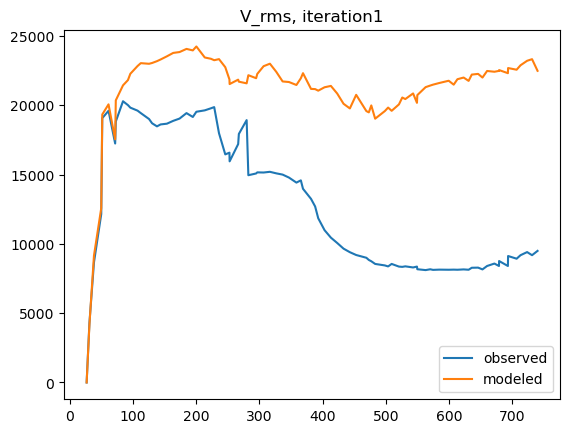

MCMC iteration: 1, likelihood:59.70709, acceptance ratio:1, random value:[ 0.072],jumped to new value
E<qsc


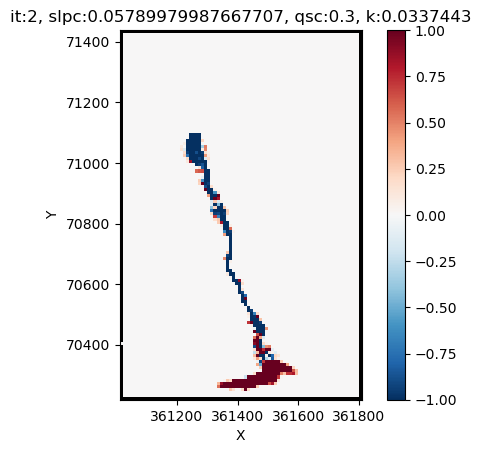

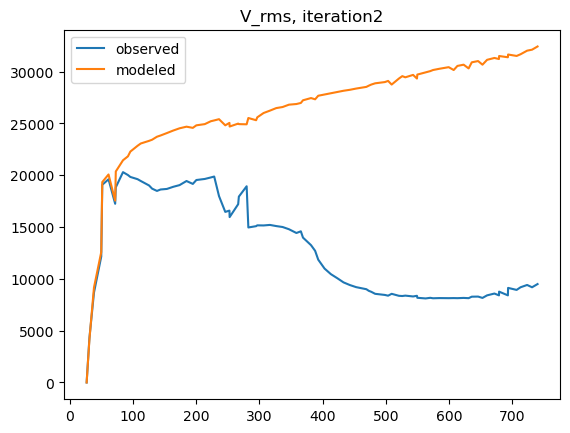

MCMC iteration: 2, likelihood:16.89081, acceptance ratio:0.283, random value:[ 0.679],staying put
E<qsc


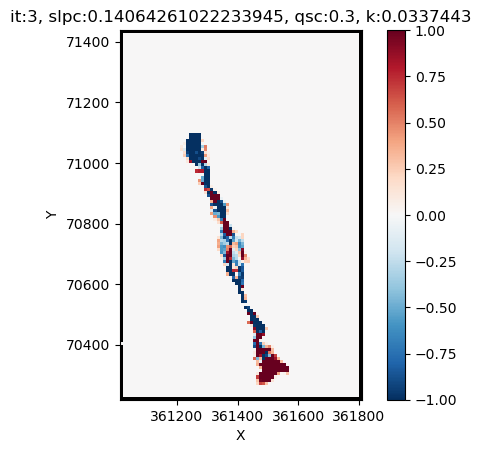

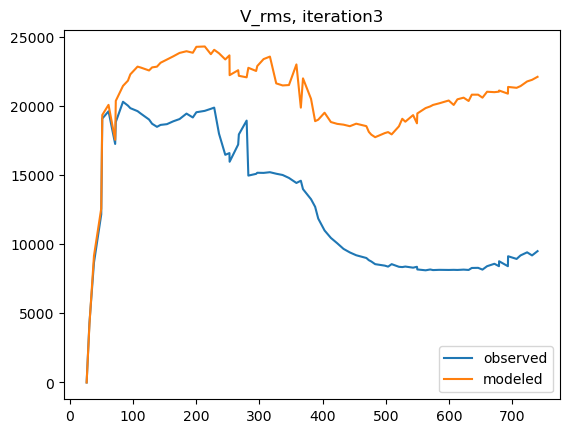

MCMC iteration: 3, likelihood:78.84556, acceptance ratio:1, random value:[ 0.066],jumped to new value
E<qsc


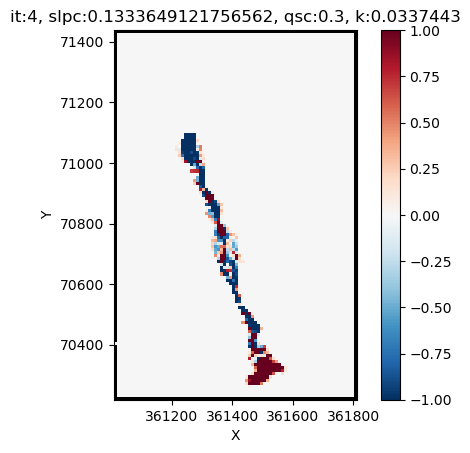

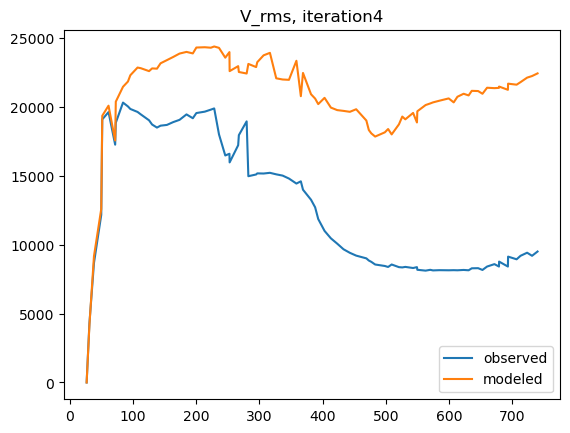

MCMC iteration: 4, likelihood:72.72547, acceptance ratio:0.922, random value:[ 0.213],jumped to new value
E<qsc


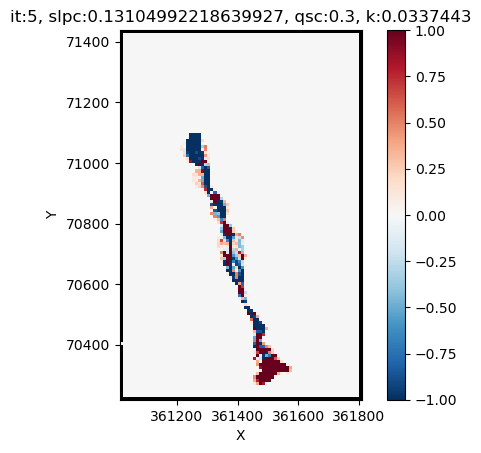

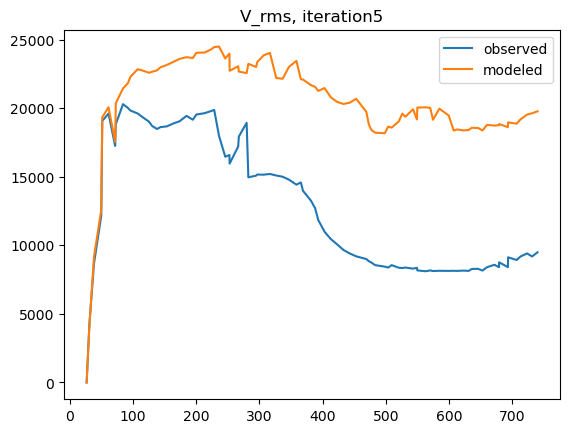

MCMC iteration: 5, likelihood:84.23919, acceptance ratio:1, random value:[ 0.025],jumped to new value
E<qsc


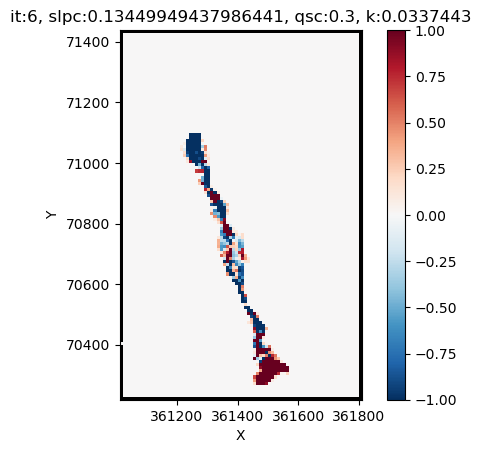

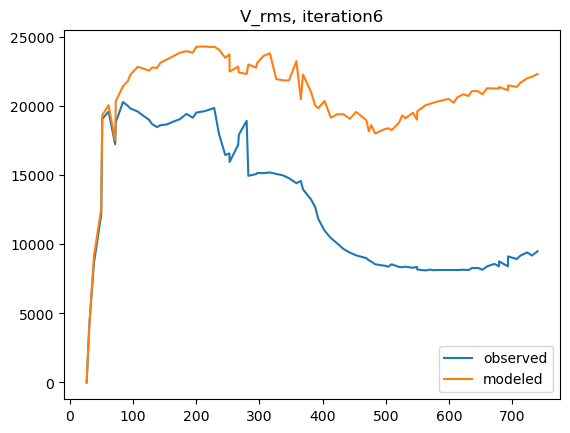

MCMC iteration: 6, likelihood:75.84777, acceptance ratio:0.9, random value:[ 0.23],jumped to new value
E<qsc


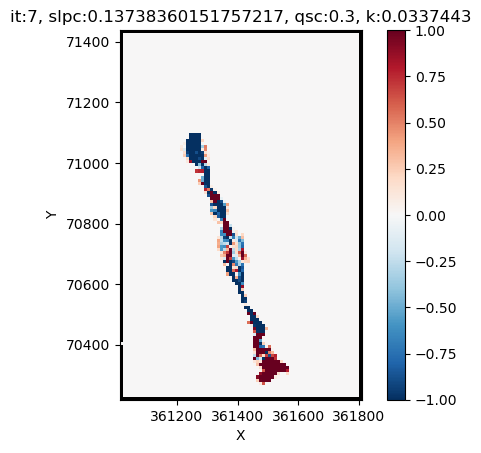

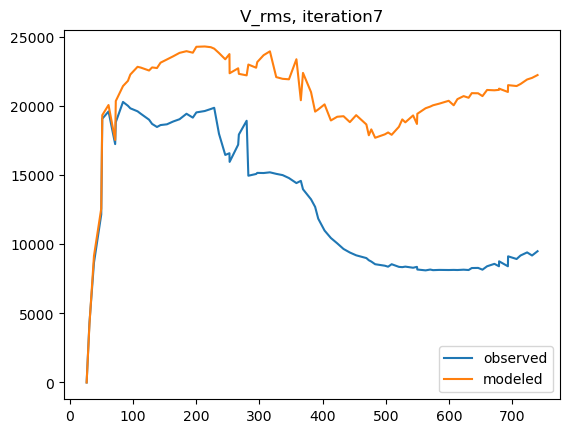

MCMC iteration: 7, likelihood:76.58732, acceptance ratio:1, random value:[ 0.133],jumped to new value
E<qsc


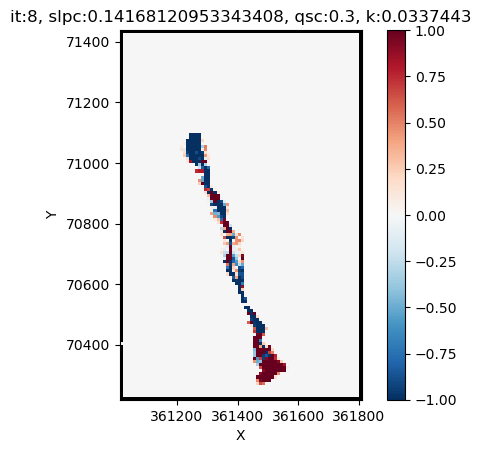

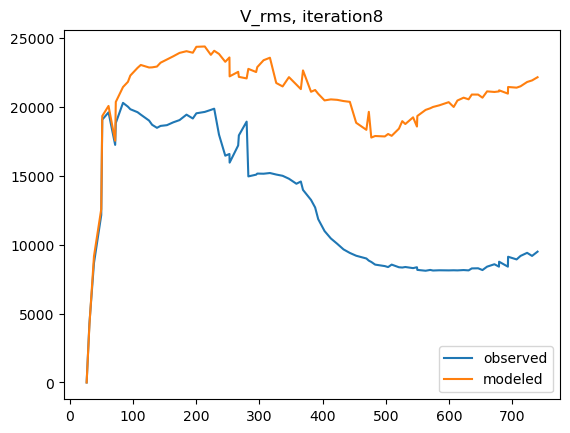

MCMC iteration: 8, likelihood:74.70365, acceptance ratio:0.975, random value:[ 0.669],jumped to new value
E<qsc


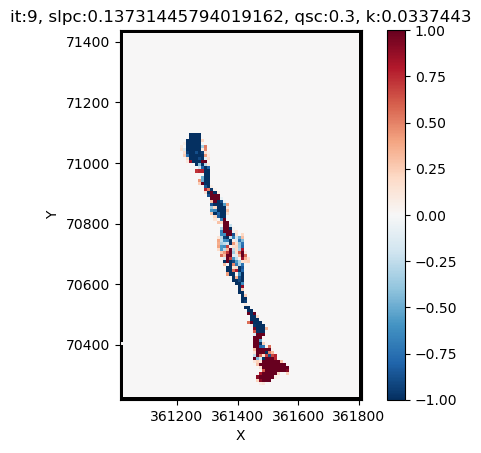

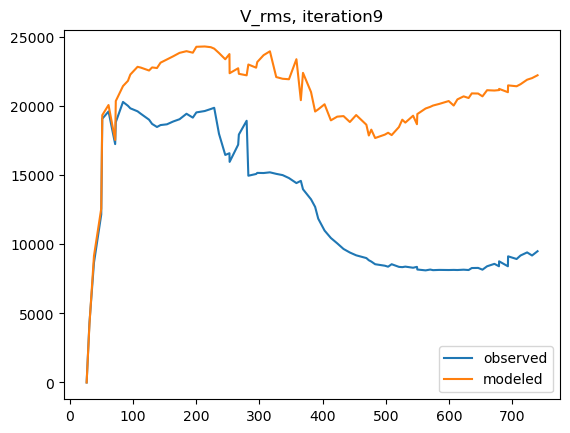

MCMC iteration: 9, likelihood:76.43131, acceptance ratio:1, random value:[ 0.491],jumped to new value


In [13]:
#%% calibrate the model 
parameters = calibrate(max_number_of_runs = max_number_of_runs) # change so that calibrator saves model run and lines, then access after is run to create videos

In [14]:
calibrate.dem_dif_m_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
len(calibrate.trial_qs_profiles.keys())

In [ ]:
# create high res hillshade plot and paper profile plot

In [15]:
def qs_plot(dist,Vu_o, Vu_m):
    fig, ax = plt.subplots(figsize=(3,1.5))
    nsteps = 50
    step = int(max(np.round(len(Vu_o)/nsteps),1))
    po = ax.plot(dist[0::step],Vu_o[0::step]*mg.dx**2,color = 'silver',marker='.', markersize = 5,linestyle = 'None', alpha = 0.5)
    pm = ax.plot(dist[0::step],Vu_m[0::step]*mg.dx**2,color = 'black', marker='.',  markersize = 3,linestyle = 'None') 
    ax.grid(alpha = 0.5)
    ax.set_xlabel('distance from crown, m')
    ax.set_ylabel('$Q_s$,' + ' $m^3$')#plt.ylabel(r'$\sum$ $Vd$', rotation = 0)
    ax.ticklabel_format(axis = 'y', style = 'sci',scilimits=(0,0))
    return fig, pm
#plt.savefig(wdir+svnm+".png", dpi = 300, bbox_inches='tight')

<IPython.core.display.Javascript object>


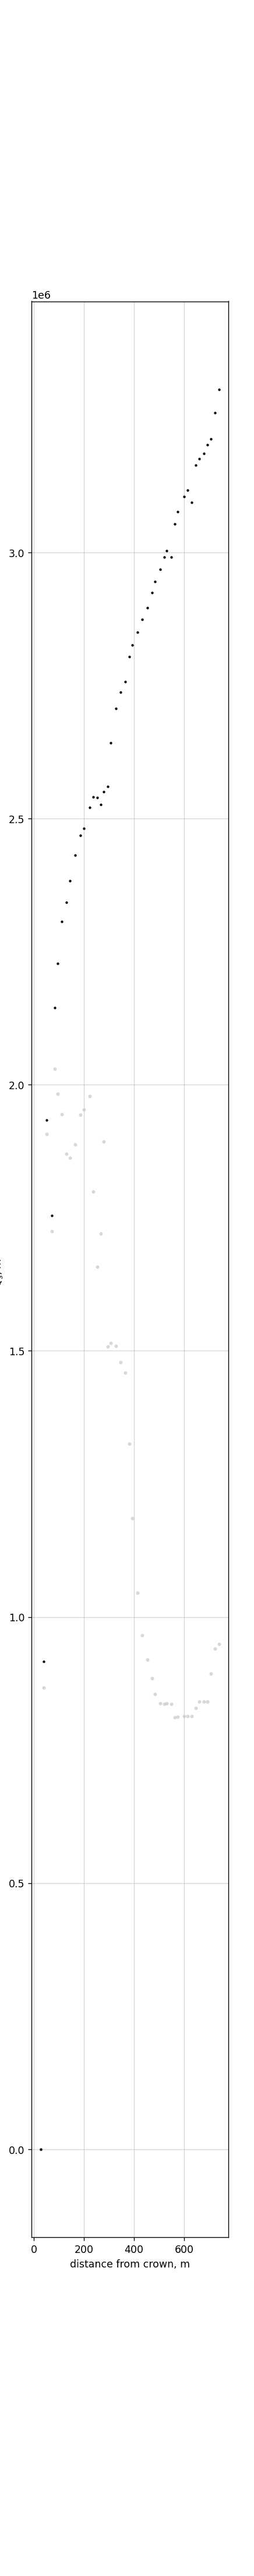

(<Figure size 300x150 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x136ddb40b10>])

In [16]:
#%matplotlib inline
%matplotlib notebook
dist = calibrate.mbLdf_m['runout_distance'].values
Vu_o = calibrate.mbLdf_o['Vu'].values
Vu_m = calibrate.trial_qs_profiles[0]

qs_plot(dist,Vu_o, Vu_m)

<IPython.core.display.Javascript object>


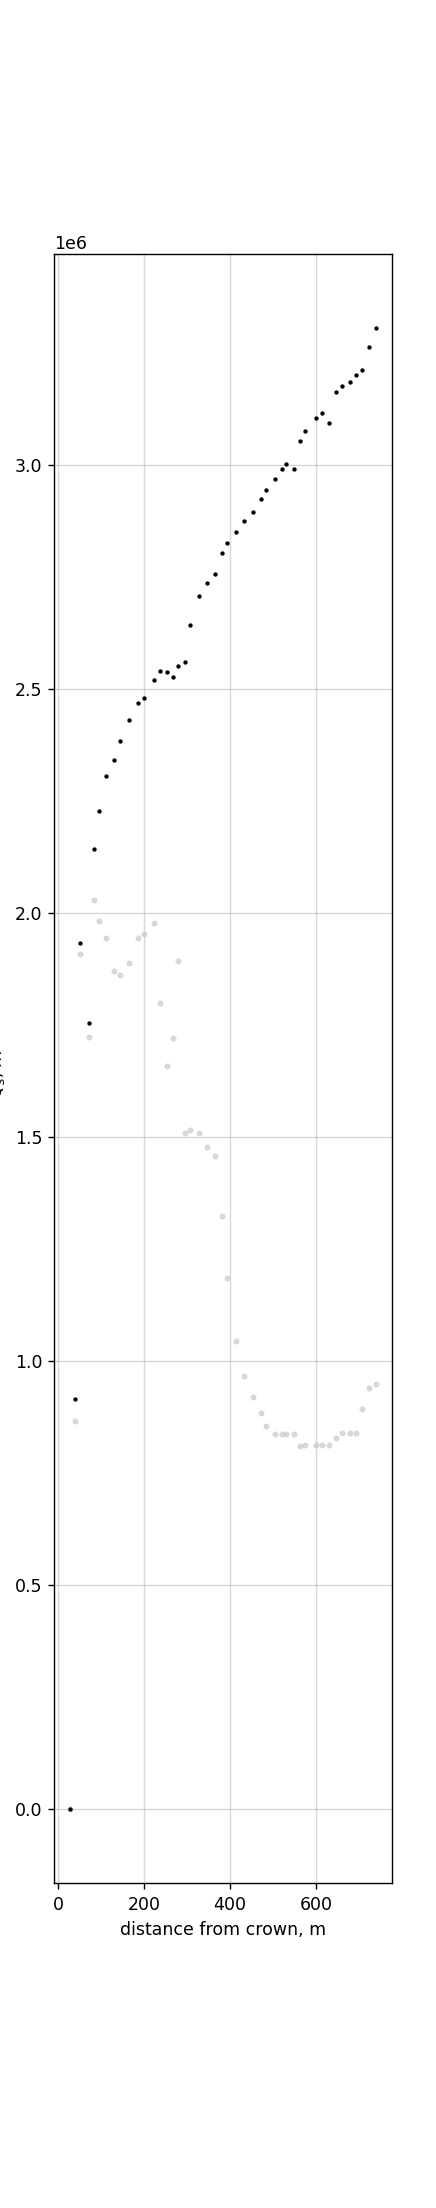

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

# prepare the first frame
dist = calibrate.mbLdf_m['runout_distance'].values
Vu_o = calibrate.mbLdf_o['Vu'].values
Vu_m = calibrate.trial_qs_profiles[0]

fig, ax = plt.subplots(figsize=(3,1.5))
nsteps = 50
step = int(max(np.round(len(Vu_o)/nsteps),1))
po = ax.plot(dist[0::step],Vu_o[0::step]*mg.dx**2,color = 'silver',marker='.', markersize = 5,linestyle = 'None', alpha = 0.5)
pm = ax.plot(dist[0::step],Vu_m[0::step]*mg.dx**2,color = 'black', marker='.',  markersize = 3,linestyle = 'None') 
ax.grid(alpha = 0.5)
ax.set_xlabel('distance from crown, m')
ax.set_ylabel('$Q_s$,' + ' $m^3$')#plt.ylabel(r'$\sum$ $Vd$', rotation = 0)
ax.ticklabel_format(axis = 'y', style = 'sci',scilimits=(0,0))

# update function
def update(frame):
    Vu_m = calibrate.trial_qs_profiles[frame]
    pm.set_xdata(dist)
    pm.set_ydata(Vu_m)
    ax.set_title('run '+str(frame))
    return (pm)
frames = len(calibrate.trial_qs_profiles.keys())
animate = animation.FuncAnimation(fig, update, frames=frames, interval=200, blit = True)
plt.show()

### plot the parameter values tested by the calibrator

<IPython.core.display.Javascript object>


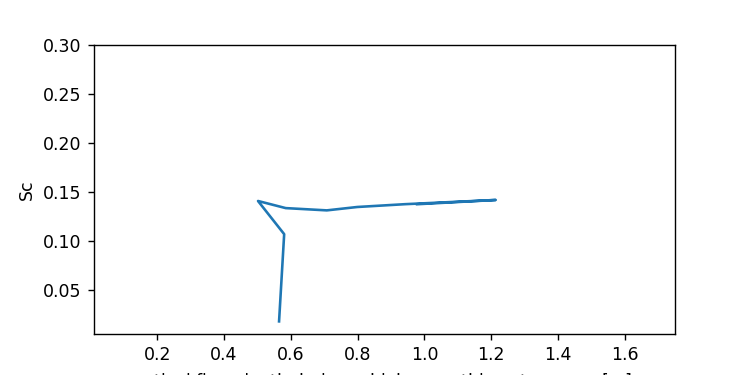

Text(0, 0.5, 'Sc')

In [18]:
#%% summarize results
results = calibrate.LHvals
results['params'] = str(calibrate.params)
results['mw_dict'] = str(mw_dict)


x_mn = params['SD'][0]
x_mx = params['SD'][1]
y_mn = params['slpc'][0]
y_mx = params['slpc'][1]

# plot jumps
plt.figure(figsize = (6,3))
plt.plot(results['selected_value_SD'], results['selected_value_slpc'])
plt.xlim([x_mn,x_mx])
plt.ylim([y_mn,y_mx])
plt.xlabel('crtical flow depth, below which everything stops $qs_c$, [m]')
plt.ylabel('Sc')


### print best model run parameter values

In [19]:

best = results[results['candidate_posterior'] == results['candidate_posterior'].max()]
print(results.iloc[best['iteration'].values[0]])


iteration                                                                 5
model iterations                                                         93
total_mobilized_volume                                         26406.602925
obs_mean_total_flow                                            12767.654094
prior                                                                     1
omegaT                                                             0.834331
MSE_Qt^1/2                                                         0.653855
Vse^1/2                                                            0.152206
candidate_posterior                                               84.239193
acceptance_ratio                                                        1.0
random value                                              [0.0248992275503]
msg                                                     jumped to new value
selected_posterior                                                84.239193
jump_size_SD

### if calibrator is run 2000 times, you get this result:

In [ ]:
#%% calibration results

csvnm = 's1000_10m_2000_ns_nmcmc.csv'#s1000_10m_200_eta0d2__mcmc.csv'#'s1000_10m_2000_omega_eta0d2__mcmc.csv' #'s1000_22_2000_0d15_mcmc.csv'
# location of calibration output
mdir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/S1000/output/MCMC_v1/'

results, best, sum_dict, params, mw_dict = MWF.calibration_results(mdir, csvnm, aspect = 'auto', fs = 13, cntrs = 6, figsize = (5,3.3),
                        save = True, svnm = 'example', wdir = 'D:/temp/', labloc = [[0.05,0.75],[0.05,0.75]])  